In [ ]:
import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=100, num_test=100, subtract_mean=False, transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2358, 1000, 22) 
y_train: (2358,) 
X_val: (100, 1000, 22) 
y_val: (100,) 
X_test: (100, 1000, 22) 
y_test: (100,) 


In [3]:
# class flatten to connect to FC layer
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H = x.size() # read in N, C, H
        return x.view(N, -1)

In [4]:
# turn x and y into torch type tensor
N_train, C_train, H_train = data.get('X_train').shape
N_val, C_val, H_val = data.get('X_val').shape
N_test, C_test, H_test = data.get('X_test').shape

dtype = torch.FloatTensor

X_train = Variable(torch.Tensor(data.get('X_train'))).type(dtype)
y_train = Variable(torch.Tensor(data.get('y_train'))).type(dtype)
X_val = Variable(torch.Tensor(data.get('X_val'))).type(dtype)
y_val = Variable(torch.Tensor(data.get('y_val'))).type(dtype)
X_test = Variable(torch.Tensor(data.get('X_test'))).type(dtype)
y_test = Variable(torch.Tensor(data.get('y_test'))).type(dtype)

In [5]:
# class for RNN model

class RNN(nn.Module):
    # input_size: number of EGG channels
    # output_size: number of classes
    # hidden_size: size of hidden layers in RNN module
    # num_layers: number of hidden layers in RNN module
    # dropout: non-zero value means applying dropout to hidden layers
    def __init__(self, input_size, output_size, hidden_size=10, num_layers=1, dropout=0):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x, y, hidden_init, T_length=1):
        N, _, _ = x.size()
        out_rnn, state_rnn = self.rnn(x, hidden_init)
        score = self.output(out_rnn)
        
        # calculate the total loss at time interval of T_length
        loss = 0
        for t in np.arange(T_length):
            yy = score[:,-(t+1),:].squeeze(1)
            loss += self.loss_fn(yy,y)
        # score[N,S,C]:
        # N: batch_size(number of time series), S: length of time series, C: number of classes
        return score[:,-1,:].squeeze(1), loss, state_rnn
    

In [7]:
# decare a RNN model

N_train, S, input_size = X_train.size()
output_size = 4
hidden_size = 40
num_layers = 2
dropout = 1

model = RNN(input_size, output_size, hidden_size, num_layers, dropout)
model.type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# train through several iterations
num_epoch = 10
batch_size = 2358

T_num_epoch = 100
T_batch_size = int(S/T_num_epoch)
step = np.arange(0,N_train+1,batch_size)
#step = np.append(step,N_train) #discard some data

loss_his = []
train_accu_his = []
val_accu_his = []

for epoch in range(num_epoch):
    for t in range(step.shape[0]-1):
        N = step[t+1] - step[t]
        for T_epoch in range(T_num_epoch):  
            print(T_epoch, loss.data.numpy())
            if T_epoch == 0: 
                hidden_init = Variable(torch.zeros(num_layers, int(N), hidden_size))

            # calculate loss
            X_train_sub = X_train[step[t]:step[t+1],:(T_epoch+1)*T_batch_size,:]    
            y_train_pred, loss, _ = model.forward(X_train_sub, y_train[step[t]:step[t+1]].type(torch.LongTensor), 
                                                      hidden_init, T_length=T_batch_size)
            # backpropagation
            model.zero_grad()
            loss.backward()

            # update parameters
            optimizer.step()
        
    # calculate predicted value for validation
    hidden_init = Variable(torch.zeros(num_layers, N_val, hidden_size))
    y_val_pred,_,_ = model(X_val,y_val.type(torch.LongTensor),hidden_init)

    # training loss
    print('Epoch ', epoch, ', loss is ', loss.data.numpy())
    _, y_pred = torch.max(y_train_pred,1)
    loss_his.append(loss.data.numpy())
    
    # training accuracy
    train_accu = np.mean(y_pred.data.numpy() == 
                                       y_train.data[step[t]:step[t+1]].numpy())
    print('Training accuracy', train_accu)
    train_accu_his.append(train_accu)

    # validation accuracy    
    _, y_pred = torch.max(y_val_pred,1)
    val_accu = np.mean(y_pred.data.numpy() ==  y_val.data.numpy())
    print('Validation accuracy', val_accu, '\n')   
    val_accu_his.append(val_accu)

0 [ 13.86315346]
1 [ 13.86517906]
2 [ 13.86302185]
3 [ 13.86305046]
4 [ 13.86305714]
5 [ 13.86291695]
6 [ 13.86301804]
7 [ 13.86350536]
8 [ 13.86323833]
9 [ 13.86331177]
10 [ 13.86328793]
11 [ 13.8631525]
12 [ 13.86309052]
13 [ 13.86264801]
14 [ 13.86280155]
15 [ 13.86287689]
16 [ 13.86288548]
17 [ 13.86282921]
18 [ 13.86289787]
19 [ 13.86278057]
20 [ 13.86261082]
21 [ 13.86283016]
22 [ 13.86262131]
23 [ 13.8628273]
24 [ 13.86283016]
25 [ 13.86286163]
26 [ 13.86287594]
27 [ 13.86289215]
28 [ 13.86281872]
29 [ 13.86269474]
30 [ 13.86260891]
31 [ 13.86284637]
32 [ 13.8626442]
33 [ 13.86257076]
34 [ 13.86245346]
35 [ 13.86268425]
36 [ 13.86283875]
37 [ 13.86292553]
38 [ 13.86266804]
39 [ 13.86281013]
40 [ 13.86263752]
41 [ 13.86264706]
42 [ 13.86266518]
43 [ 13.86285686]
44 [ 13.86284924]
45 [ 13.86254406]
46 [ 13.86261082]
47 [ 13.86293507]
48 [ 13.86262035]
49 [ 13.86252403]
50 [ 13.86285591]
51 [ 13.86285591]
52 [ 13.86284924]
53 [ 13.86262035]
54 [ 13.8626442]
55 [ 13.86263943]
56 [ 1

41 [ 13.86242867]
42 [ 13.86261749]
43 [ 13.86263657]
44 [ 13.86262989]
45 [ 13.86263847]
46 [ 13.86273956]
47 [ 13.86282921]
48 [ 13.86283779]
49 [ 13.86275864]
50 [ 13.86272049]
51 [ 13.86272335]
52 [ 13.86262798]
53 [ 13.86264896]
54 [ 13.86284924]
55 [ 13.86283684]
56 [ 13.86262894]
57 [ 13.8627634]
58 [ 13.86285591]
59 [ 13.8627615]
60 [ 13.86274147]
61 [ 13.86283779]
62 [ 13.86283016]
63 [ 13.86274147]
64 [ 13.86275482]
65 [ 13.86284924]
66 [ 13.86274242]
67 [ 13.86283112]
68 [ 13.86283779]
69 [ 13.86283684]
70 [ 13.86285686]
71 [ 13.86284733]
72 [ 13.86283016]
73 [ 13.8627634]
74 [ 13.8627634]
75 [ 13.86284924]
76 [ 13.86284733]
77 [ 13.86285019]
78 [ 13.86278534]
79 [ 13.8627634]
80 [ 13.8627634]
81 [ 13.8627615]
82 [ 13.86278248]
83 [ 13.86276245]
84 [ 13.86275864]
85 [ 13.86275864]
86 [ 13.8627634]
87 [ 13.86276245]
88 [ 13.86275387]
89 [ 13.86285019]
90 [ 13.86284924]
91 [ 13.86275864]
92 [ 13.8627615]
93 [ 13.8627615]
94 [ 13.8627615]
95 [ 13.86276245]
96 [ 13.8627615]
97 [

In [8]:
np.set_printoptions(threshold=np.nan)
y_temp = y_pred.data.numpy()
#print(y_temp)
np.isnan(np.sum(y_temp))


False

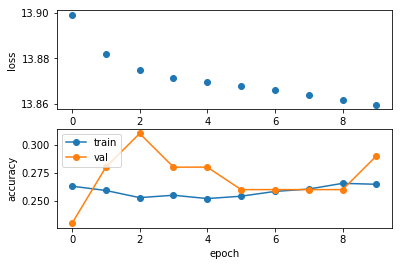

In [9]:
# plot training and validation history
plt.subplot(2, 1, 1)
plt.plot(loss_his, 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(train_accu_his, '-o')
plt.plot(val_accu_his, '-o')
plt.legend(['train','val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

In [10]:
# test set
hidden_init = Variable(torch.zeros(num_layers, N_test, hidden_size))
y_test_pred,_,_ = model(X_test,y_test.type(torch.LongTensor),hidden_init)
  
_, y_pred = torch.max(y_test_pred,1)
test_accu = np.mean(y_pred.data.numpy() ==  y_test.data.numpy())
print('Test accuracy', test_accu, '\n')   

Test accuracy 0.17 

